In [1]:
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

import warnings
warnings.filterwarnings("ignore")

dataset_path = '/mnt/dataset_drive/ayad/phantom-touch/data/output/handover_collection_0/dataset'

In [2]:
# def create_sample_indices(
#         episode_ends:np.ndarray, sequence_length:int,
#         pad_before: int=0, pad_after: int=0):
#     indices = list()
#     for i in range(len(episode_ends)):
#         start_idx = 0
#         if i > 0:
#             start_idx = episode_ends[i-1]
#         end_idx = episode_ends[i]
#         episode_length = end_idx - start_idx

#         min_start = -pad_before
#         max_start = episode_length - sequence_length + pad_after

#         # range stops one idx before end
#         for idx in range(min_start, max_start+1):
#             buffer_start_idx = max(idx, 0) + start_idx
#             buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
#             start_offset = buffer_start_idx - (idx+start_idx)
#             end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
#             sample_start_idx = 0 + start_offset
#             sample_end_idx = sequence_length - end_offset
#             indices.append([
#                 buffer_start_idx, buffer_end_idx,
#                 sample_start_idx, sample_end_idx])
#     indices = np.array(indices)
#     return indices


# def sample_sequence(train_data, sequence_length,
#                     buffer_start_idx, buffer_end_idx,
#                     sample_start_idx, sample_end_idx):
#     result = dict()
#     for key, input_arr in train_data.items():
#         sample = input_arr[buffer_start_idx:buffer_end_idx]
#         data = sample
#         if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
#             data = np.zeros(
#                 shape=(sequence_length,) + input_arr.shape[1:],
#                 dtype=input_arr.dtype)
#             if sample_start_idx > 0:
#                 data[:sample_start_idx] = sample[0]
#             if sample_end_idx < sequence_length:
#                 data[sample_end_idx:] = sample[-1]
#             data[sample_start_idx:sample_end_idx] = sample
#         result[key] = data
#     return result


In [3]:
# episode_ends = [10, 20, 35]
# pred_horizon = 11
# sequence_length = pred_horizon
# obs_horizon = 11
# action_horizon = 1
# pad_before = obs_horizon - 1
# pad_after = action_horizon - 1

# indices = create_sample_indices(episode_ends, sequence_length, pad_before, pad_after)

In [4]:
# data = {'data': np.arange(35)}
# for k in range(len(indices)):
#     data_sample = sample_sequence(data, sequence_length, indices[k][0], indices[k][1], indices[k][2], indices[k][3])
#     print(data_sample)

In [5]:
from data import HandoverDataset, unnormalize_data
from train_eval import create_train_test_datasets, read_config

config_path = './config.yaml'
config = read_config(config_path)

config['batch_size'] = 1
config['eval_batch_size'] = 1

config['obs_horizon'] = 4
config['pred_horizon'] = 8

train_dataset, test_dataset, data_stats = create_train_test_datasets(dataset_path, config)

In [6]:
data_stats, len(train_dataset), len(test_dataset)

({'states': {'min': array([-2.30929728e+00, -1.51330374e+00, -7.68017094e-01, -2.73003319e+00,
          -1.67711730e+00,  1.02619789e+00, -5.80947050e-01,  3.57629059e-01,
          -2.90176875e-01,  2.91250149e-02, -2.87453170e+00, -2.94765999e+00,
           2.56607374e-04,  1.90082802e-01]),
   'max': array([ 1.38104876,  0.97740626,  2.49369771, -0.74030973,  2.03954609,
           4.20939995,  2.68950001,  0.77650735,  0.30132633,  0.68860281,
           2.84869941,  0.00993571,  3.14118305,  1.        ])},
  'actions': {'min': array([ 0.37142543, -0.29017968,  0.02912478, -3.12693857, -0.01108169,
          -3.14156059,  0.00979206]),
   'max': array([0.77983133, 0.30132673, 0.68860539, 3.13951649, 1.55588988,
          3.14027772, 2.9241933 ])}},
 2204,
 296)

In [17]:
def tensor_to_image(image_tensor, batch_idx):
    num_images = image_tensor.shape[1]
    fig, ax = plt.subplots(1, num_images, figsize=(12, 6))
    
    for image_idx in range(num_images):
        im = np.float32(image_tensor[batch_idx, image_idx].permute(1, 2, 0).detach().cpu().numpy())
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        ax[image_idx].imshow(im)
        ax[image_idx].set_title(f"{image_idx}")
        ax[image_idx].set_axis_off()
    plt.show()

def plot_image_actions(image_tensor, action_tensor, batch_idx):

    

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)  # <- Enable 3D
    ax1.set_title("Image")
    im = np.float32(image_tensor[batch_idx, -1].permute(1, 2, 0).detach().cpu().numpy())
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax1.imshow(im)

    gtaction = action_tensor.detach().cpu().numpy()

    # Plot GT and Predicted points in green and red
    ax2.plot(gtaction[batch_idx, :, 0], gtaction[batch_idx, :, 1], c='green')

    ax2.scatter(gtaction[batch_idx, :, 0], gtaction[batch_idx, :, 1], c='green', s=20)

    xmin, xmax = data_stats['actions']['min'][0], data_stats['actions']['max'][0]
    ymin, ymax = data_stats['actions']['min'][1], data_stats['actions']['max'][1]
    xmid = xmin + (xmax - xmin) / 2.0
    ymid = ymin + (ymax - ymin) / 2.0
    xmid_range = (xmax - xmin) / 2.0
    ymid_range = (ymax - ymin) / 2.0

    ax2.set_xlim(-ymin, -ymax)
    ax2.set_ylim(xmin, xmax)
    
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    # ax2.set_zlabel('Z')

    plt.show()    

In [13]:
data_stats

{'states': {'min': array([-1.40157349, -1.51330068,  1.50960138, -2.38837649, -0.18592464,
          2.197324  ,  1.88757569,  0.56080175, -0.05916968,  0.31146719,
         -1.16088572, -2.12775208,  0.01900459,  0.44583935]),
  'max': array([-1.33547054, -1.18853304,  1.61605525, -2.13811036, -0.11808409,
          2.54311214,  2.14110912,  0.57241774,  0.02446805,  0.34827042,
          1.98598131, -1.04096056,  3.09542287,  0.55186112])},
 'actions': {'min': array([ 0.56081592, -0.05917085,  0.3114457 , -2.09021962,  1.01246627,
         -3.12168662,  0.44583554]),
  'max': array([ 0.57242033, -0.01154065,  0.34511505, -1.35123722,  1.25681917,
          3.09679526,  0.5539683 ])}}

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='70%'), max=23), Output()), _d…

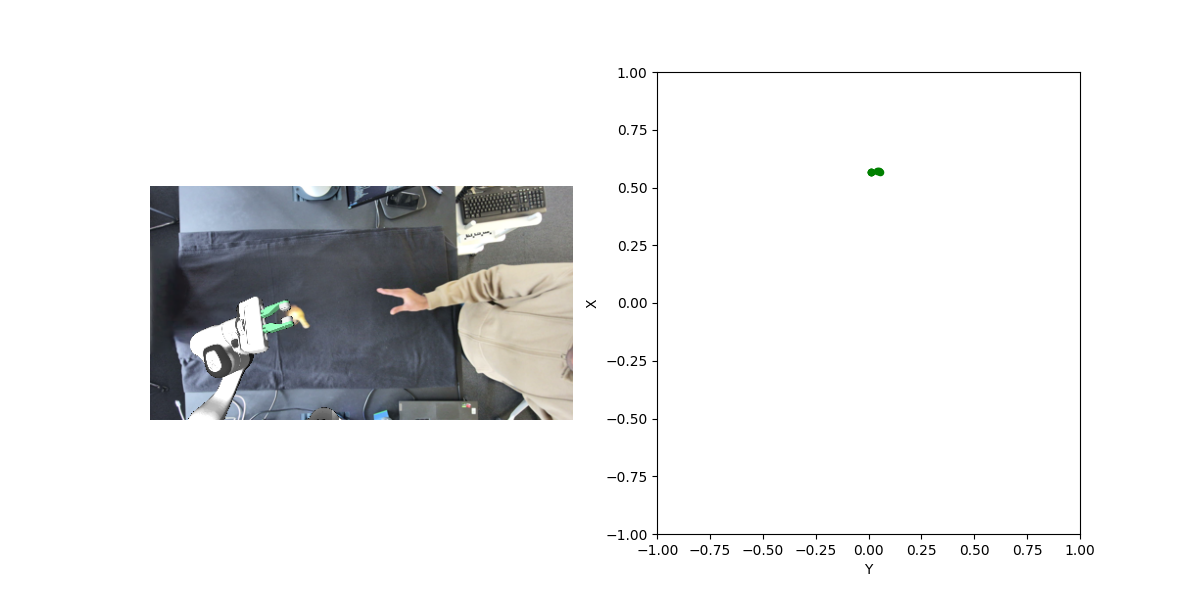

In [21]:
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout, HBox, VBox
import pickle 

%matplotlib widget

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)  # <- Enable 3D
ax1.set_axis_off()

image_1 = ax1.imshow(np.zeros((240, 432, 3)) / 255.0)
batch_idx = 0

tmpx_values = []
tmpy_values = []
tmpz_values = []

def update(idx):
    ax2.cla()
    data = train_dataset[idx]

    nImage = data['image']
    gtaction = data['actions'] # Normalized actions
    nstate = data['states']
    
    im = np.float32(np.moveaxis(nImage[-1], 0, -1))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_1.set_data(im)

    gtaction = unnormalize_data(gtaction, data_stats['actions'])
    # naction = naction.detach().cpu().numpy()

    # Plot GT and Predicted points in green and red

    tmpx_values.append(gtaction[:, 0])
    tmpy_values.append(gtaction[:, 1])
    tmpz_values.append(gtaction[:, 2])
    

    x_val = -gtaction[:, 1]
    y_val = gtaction[:, 0]
    ax2.plot(x_val, y_val, c='green')

    ax2.scatter(x_val, y_val, c='green', s=20)

    xmin, xmax = data_stats['actions']['min'][0], data_stats['actions']['max'][0]
    ymin, ymax = data_stats['actions']['min'][1], data_stats['actions']['max'][1]
    xmid = xmin + (xmax - xmin) / 2.0
    ymid = ymin + (ymax - ymin) / 2.0
    xmid_range = (xmax - xmin) / 2.0
    ymid_range = (ymax - ymin) / 2.0

    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    
    ax2.set_xlabel('Y')
    ax2.set_ylabel('X')    
    
    fig.canvas.draw_idle()

# Slider
slider = widgets.IntSlider(min=0, max=len(train_dataset) - 1, step=1, value=0, layout=Layout(width='70%'))

# Buttons
button_prev = widgets.Button(description="◀ Prev", layout=Layout(width="100px"))
button_next = widgets.Button(description="Next ▶", layout=Layout(width="100px"))

# Button click functions
def on_prev_click(b):
    if slider.value > slider.min:
        slider.value -= 1

def on_next_click(b):
    if slider.value < slider.max:
        slider.value += 1

# Connect buttons to functions
button_prev.on_click(on_prev_click)
button_next.on_click(on_next_click)

# Display UI elements
ui = HBox([button_prev, slider, button_next])
interact(update, idx=slider)
display(ui)


In [ ]:
data_stats

In [ ]:
d = np.moveaxis(data['image'][-1], 0, -1)

In [ ]:
d.shape

In [ ]:
for idx, data in enumerate(train_loader):
    if idx % 10 != 0:
        continue
    print(f"Data sample: {idx}")
    nImage = data['image']
    naction = data['actions']
    nstate = data['states']

    # tensor_to_image(nImage, 0)
    unnormalized_actions = unnormalize_data(naction, data_stats['actions'])

    plot_image_actions(nImage, naction, 0)

    pdb.set_trace()

In [ ]:
len(train_loader)

In [ ]:
import re
npzFiles = [os.path.join(dirs[0], file) for dirs in os.walk(dataset_path, topdown=True) for file in dirs[2] if file.endswith(".npz")]

sorted_paths = sorted(npzFiles, key=lambda s: int(re.search(r'_e(\d+)\.npz$', s).group(1)))
print(sorted_paths)

min_shape = 100000
ep_shapes = []
for npz_file in npzFiles:
    data = np.load(npz_file)

    actions = data['action']
    if actions.shape[0] > 20 and actions.shape[0] < 30:
        pdb.set_trace()
        ep_shapes.append(actions[-1])

    euler_rot = actions
    observations = data['image_0']
    states = data['state']

In [ ]:
np.max(ep_shapes)

In [ ]:
sorted_paths[91]